<a href="https://colab.research.google.com/github/Gayeon6423/Analysis-of-Resource-Allocation-Efficiency-in-Manufacturing-Industry-Linked-to-Greenhouse-Gas-Data/blob/main/Modeling_Total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load Library & Data

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1-1. Load Library

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

### 1-2. Data Load

In [135]:
file_path = '/content/drive/MyDrive/SSK_한국연구재단(2023)/(소논문)온실가스 데이터와 연계한 지역간 제조업 자원배분 효율성 분석/data/'
city_data = pd.read_csv(file_path + 'manu_city_data.csv')
daegu_gas = pd.read_csv(file_path + '온실가스 데이터/Daegu.csv')
daejeon_gas = pd.read_csv(file_path + '온실가스 데이터/daejeon.csv')
incheon_gas = pd.read_csv(file_path + '온실가스 데이터/Incheon.csv')
ulsan_gas = pd.read_csv(file_path + '온실가스 데이터/Ulsan.csv')

In [136]:
city_mapping = {11:'서울',
                21:'부산',
                22:'대구',
                23:'인천',
                24:'광주',
                25:'대전',
                26:'울산'}
city_data['c_city'].replace(city_mapping, inplace=True)

### 1-3. data 명세

- Product function : Y = A * L^alpha * K^beta * E^(1-alpha-beta)
- Labor : pay1 + pay3
- Kapital : (fasset_b + fasset_e) / 2  
- Eenergy : cost_fuel + cost_elec
- Y(productivity) : vadd

In [137]:
city_data = city_data[['id','c1','c2','c3','year','c_city','pay1','pay3','fasset_b','fasset_e','cost_fuel','cost_elec','vadd']]

## 2. Data Preprocessing

### 2-1. 결측치 제거

In [138]:
# 결측치가 있는 행 제거
city_data = city_data.dropna()
# 결측치 확인
city_data.isnull().sum()

id           0
c1           0
c2           0
c3           0
year         0
c_city       0
pay1         0
pay3         0
fasset_b     0
fasset_e     0
cost_fuel    0
cost_elec    0
vadd         0
dtype: int64

### 2-2. 변수 생성

In [139]:
city_data['Labor'] = city_data['pay1'] + city_data['pay3']
city_data['Kapital'] = (city_data['fasset_b'] + city_data['fasset_b']) / 2
city_data['Energy'] = city_data['cost_fuel'] + city_data['cost_elec']

### 2-3. 실질 변수 변환
- 제조업 생산자물가지수 : 119.84
- 실질변수 = 명목변수 / 제조업 생산자물가지수

In [140]:
price_index = 119.84
city_data['Labor_real'] = city_data['Labor'] / price_index
city_data['Kapital_real'] = city_data['Kapital'] / price_index
city_data['Energy_real'] = city_data['Energy'] / price_index
city_data['productivity_real'] = city_data['vadd'] / price_index

### 2-4. 각 변수 값 / 2자릿수 기준 산업평균 값

In [141]:
# 산업코드(c2,c3) 분류의 가중평균 값(가중치 : 부가가치)
labor_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Labor_real'] * x['vadd']).sum() / x['vadd'].sum())
kapital_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Kapital_real'] * x['vadd']).sum() / x['vadd'].sum())
energy_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['Energy_real'] * x['vadd']).sum() / x['vadd'].sum())
productivity_weight_mean = city_data.groupby(['c2','c3']).apply(lambda x: (x['productivity_real'] * x['vadd']).sum() / x['vadd'].sum())
print(productivity_weight_mean)

c2  c3
7   0      14.787239
    1      85.671517
    2     108.025940
    3     175.311866
10  0     548.068549
             ...    
36  3      33.752190
    4      38.075441
    5      11.405750
    9      74.880631
37  0      31.523639
Length: 179, dtype: float64


In [142]:
# 가중평균을 데이터프레임으로 변환
labor_weight_mean_df = labor_weight_mean.reset_index(name='labor_weight_mean')
kapital_weight_mean_df = kapital_weight_mean.reset_index(name='kapital_weight_mean')
energy_weight_mean_df = energy_weight_mean.reset_index(name='energy_weight_mean')
productivity_weight_mean_df = productivity_weight_mean.reset_index(name='productivity_weight_mean')

In [143]:
# 기존 데이터프레임에 'c2'와 'c3' 값을 기준으로 가중평균 값 병합
city_data =  city_data.merge(labor_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(kapital_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(energy_weight_mean_df, on=['c2', 'c3'])
city_data =  city_data.merge(productivity_weight_mean_df, on=['c2', 'c3'])

In [144]:
# 해당기업 값 / 산업코드 기준 가중평균 값
city_data['Labor_real_mean'] = city_data['Labor_real'] / city_data['labor_weight_mean']
city_data['Kapital_real_mean'] = city_data['Kapital_real'] / city_data['kapital_weight_mean']
city_data['Energy_real_mean'] = city_data['Energy_real'] / city_data['energy_weight_mean']
city_data['productivity_real_mean'] = city_data['productivity_real'] / city_data['productivity_weight_mean']

city_data[['productivity_real','productivity_weight_mean','productivity_real_mean']]

,productivity_real,productivity_weight_mean,productivity_real_mean
0,3.446262,323.694616,0.010647
1,19.367490,323.694616,0.059833
2,15.078438,323.694616,0.046582
3,32.459947,323.694616,0.100280
4,1.226636,323.694616,0.003789
...,...,...,...
585588,20.085113,85.671517,0.234443
585589,47.488318,85.671517,0.554307
585590,67.481642,85.671517,0.787679
585591,253.996996,260.461241,0.975182


### 2-5. log변환

In [145]:
# 마이너스 무한대 방지를 위해서 +0.01
city_data['Labor_real_mean_log'] = np.log(city_data['Labor_real_mean']+0.01)
city_data['Kapital_real_mean_log'] = np.log(city_data['Kapital_real_mean']+0.01)
city_data['Energy_real_mean_log'] = np.log(city_data['Energy_real_mean']+0.01)
city_data['productivity_real_mean_log'] = np.log(city_data['productivity_real_mean']+0.01)
city_data = city_data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 3. Regression Modeling

### 3-1. Robustness Check(전체 기간, 전체 지역)

- OLS regression

In [41]:
# 종속변수 저장
target = city_data[['productivity_real_mean_log']]

# 독립변수 저장
x_data = city_data[['Labor_real_mean_log', 'Kapital_real_mean_log', 'Energy_real_mean_log']]

# 선형회귀분석을 위한 b0항(상수항) 추가
x_data_b0 = sm.add_constant(x_data, has_constant='add')

# 회귀모델 적합
model = sm.OLS(target, x_data_b0)
fitted_model = model.fit()

# 잔차항 계산
residuals = fitted_model.resid

# y_hat계산 : y_hat = beta0*X0 + beta1*X1 + beta2*X2 + beta3*X3
params = fitted_model.params
pred = np.dot(x_data_b0, params)
pred = pd.Series(pred)

# OLS 결과 출력
print(fitted_model.summary())

                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.873
Model:                                    OLS   Adj. R-squared:                  0.873
Method:                         Least Squares   F-statistic:                 1.339e+06
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:09:46   Log-Likelihood:            -2.9135e+05
No. Observations:                      584712   AIC:                         5.827e+05
Df Residuals:                          584708   BIC:                         5.827e+05
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [42]:
def plot_residuals(pred, residuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(pred, residuals)
    plt.axhline(y=0, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

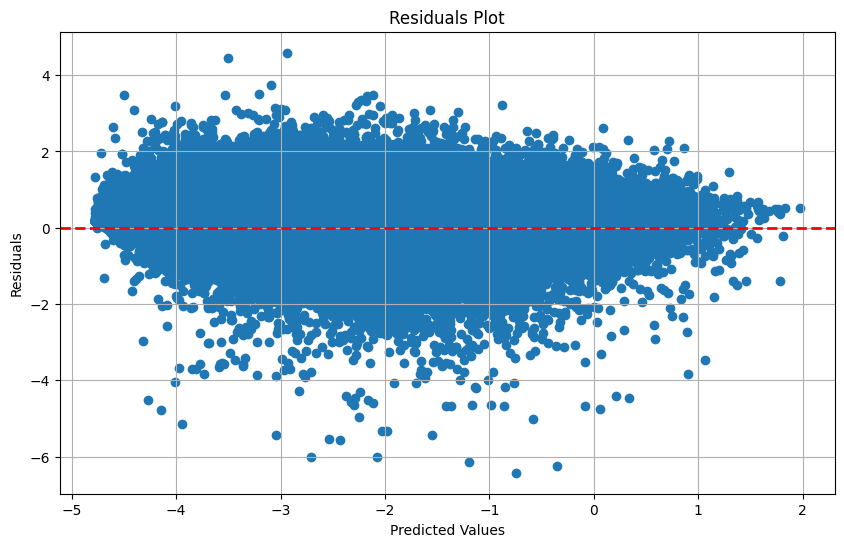

In [43]:
# residual plot
plot_residuals(pred, residuals)

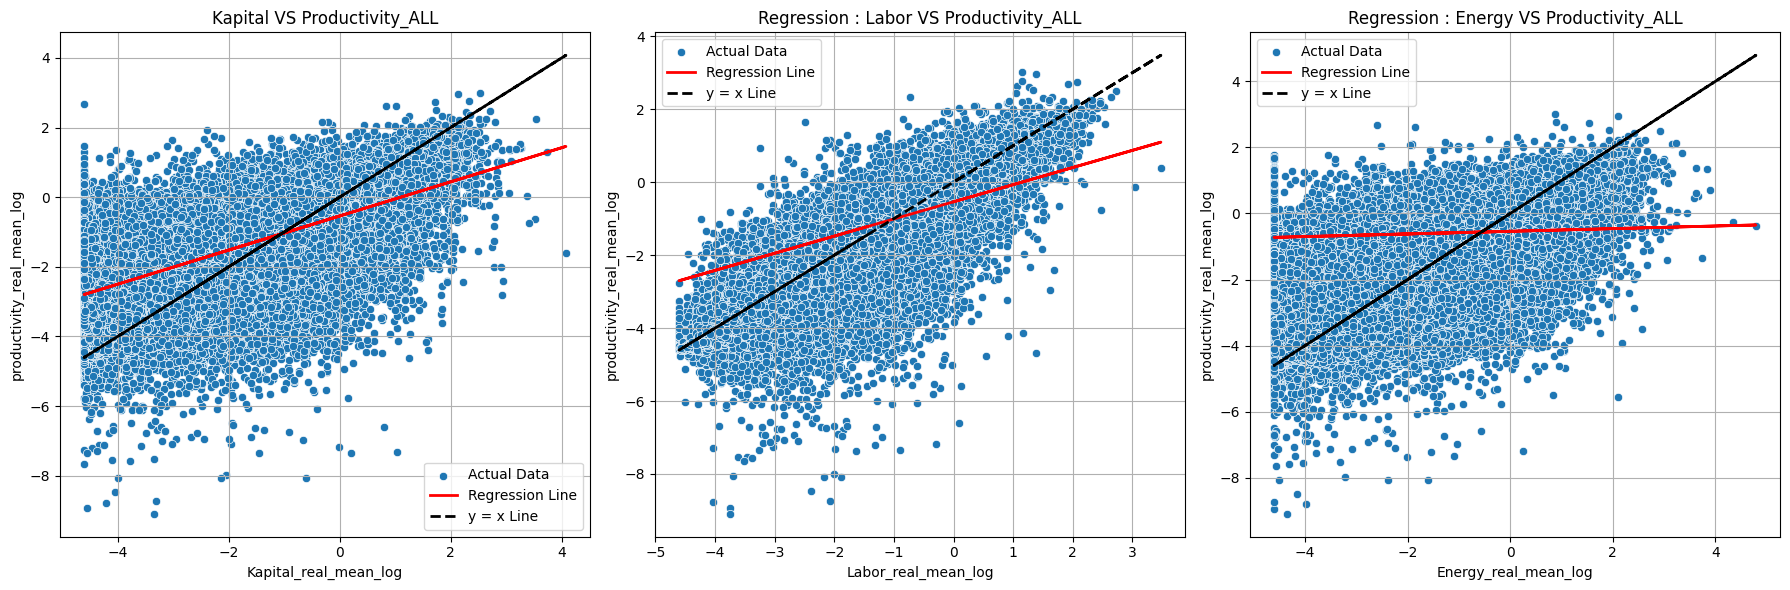

In [44]:
# 지정된 노동 비중, 자본 비중, 에너지 비중 사용
plt.figure(figsize=(18, 6))
beta0 = fitted_model.params['const']

# 첫 번째 서브플롯: Kapital vs Productivity
plt.subplot(131)
sns.scatterplot(x='Kapital_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Kapital_real_mean_log'], beta0 + 0.49 * x_data['Kapital_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Kapital_real_mean_log'], x_data['Kapital_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Kapital VS Productivity_ALL')
plt.xlabel('Kapital_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 두 번째 서브플롯: Labor vs Productivity
plt.subplot(132)
sns.scatterplot(x='Labor_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Labor_real_mean_log'], beta0 + 0.47 * x_data['Labor_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Labor_real_mean_log'], x_data['Labor_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Regression : Labor VS Productivity_ALL')
plt.xlabel('Labor_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 세 번째 서브플롯: Energy vs Productivity
plt.subplot(133)
sns.scatterplot(x='Energy_real_mean_log', y='productivity_real_mean_log', data=city_data, label='Actual Data')
plt.plot(x_data['Energy_real_mean_log'], beta0 + 0.04 * x_data['Energy_real_mean_log'], color='red', linewidth=2, label='Regression Line')
plt.plot(x_data['Energy_real_mean_log'], x_data['Energy_real_mean_log'], color='black', linewidth=2, linestyle='dashed', label='y = x Line')
plt.title('Regression : Energy VS Productivity_ALL')
plt.xlabel('Energy_real_mean_log')
plt.ylabel('productivity_real_mean_log')
plt.legend()
plt.grid()

# 서브플롯 간 간격 조정 및 그래프 표시
plt.tight_layout()
plt.show()

### 3-2. 행정구역별 연도별 회귀분석 및 산포도

In [45]:
# 연도별로 회귀분석을 수행하는 함수 정의
def perform_regression(year, city_data):
    # 종속변수 저장
    target = city_data[['productivity_real_mean_log']]
    # 독립변수 저장
    x_data = city_data[['Labor_real_mean_log', 'Kapital_real_mean_log', 'Energy_real_mean_log']]
    # 선형회귀분석을 위한 b0항(상수항) 추가
    x_data_b0 = sm.add_constant(x_data, has_constant='add')
    # 회귀모델 적합
    model = sm.OLS(target, x_data_b0)
    fitted_model = model.fit()
    params = fitted_model.params
    # y_hat 계산
    pred = np.dot(x_data_b0, params)
    pred = pd.Series(pred)
    # OLS 결과 출력
    print(f"Regression Results for {year}:")
    print(fitted_model.summary())
    print("\n")

# 연도별로 산점도와 회귀선 시각화하는 함수 정의
def plot_scatter_and_regression(year, city_data, var, ax):
    sns.set(style="whitegrid")

    # 서브플롯에서 회귀선을 빨간색 점선으로 설정
    sns.regplot(x=var, y='productivity_real_mean_log', data=city_data,
                line_kws={'color': 'red', 'linestyle': '--'}, ax=ax)

    # (0, 0)을 지나는 검은색 점선 추가
    ax.plot([city_data[var].min(), city_data[var].max()],
             [city_data[var].min(), city_data[var].max()],
             linestyle='--', color='black', linewidth=2)

    ax.set_title(f'{city_name}_{year}_{var}')

# 연도
years = [1999, 2009, 2019]
var = 'Energy_real_mean_log'

- 행정구역 : 서울

In [146]:
# 행정지역 필터링
city = '서울'
city_name = 'seoul'
city_data_seoul = city_data[city_data['c_city'] == city]

In [47]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data[city_data['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.870
Model:                                    OLS   Adj. R-squared:                  0.870
Method:                         Least Squares   F-statistic:                 9.574e+04
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:10   Log-Likelihood:                -16126.
No. Observations:                       42983   AIC:                         3.226e+04
Df Residuals:                           42979   BIC:                         3.230e+04
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

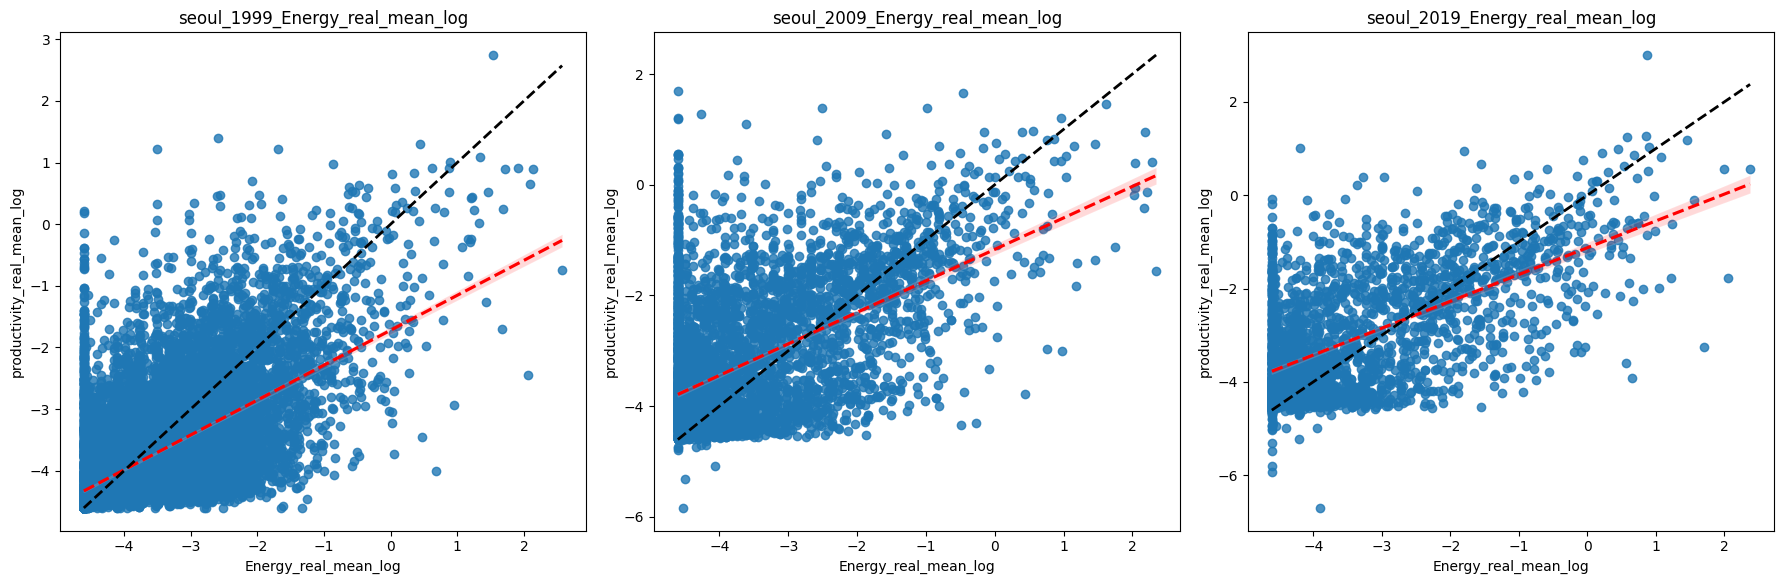

In [48]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_seoul[city_data_seoul['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 부산

In [49]:
# 행정지역 필터링
city = '부산'
city_name = 'busan'
city_data_busan = city_data[city_data['c_city'] == city]

In [50]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_busan[city_data_busan['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.880
Model:                                    OLS   Adj. R-squared:                  0.880
Method:                         Least Squares   F-statistic:                 2.119e+04
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:13   Log-Likelihood:                -3424.0
No. Observations:                        8646   AIC:                             6856.
Df Residuals:                            8642   BIC:                             6884.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

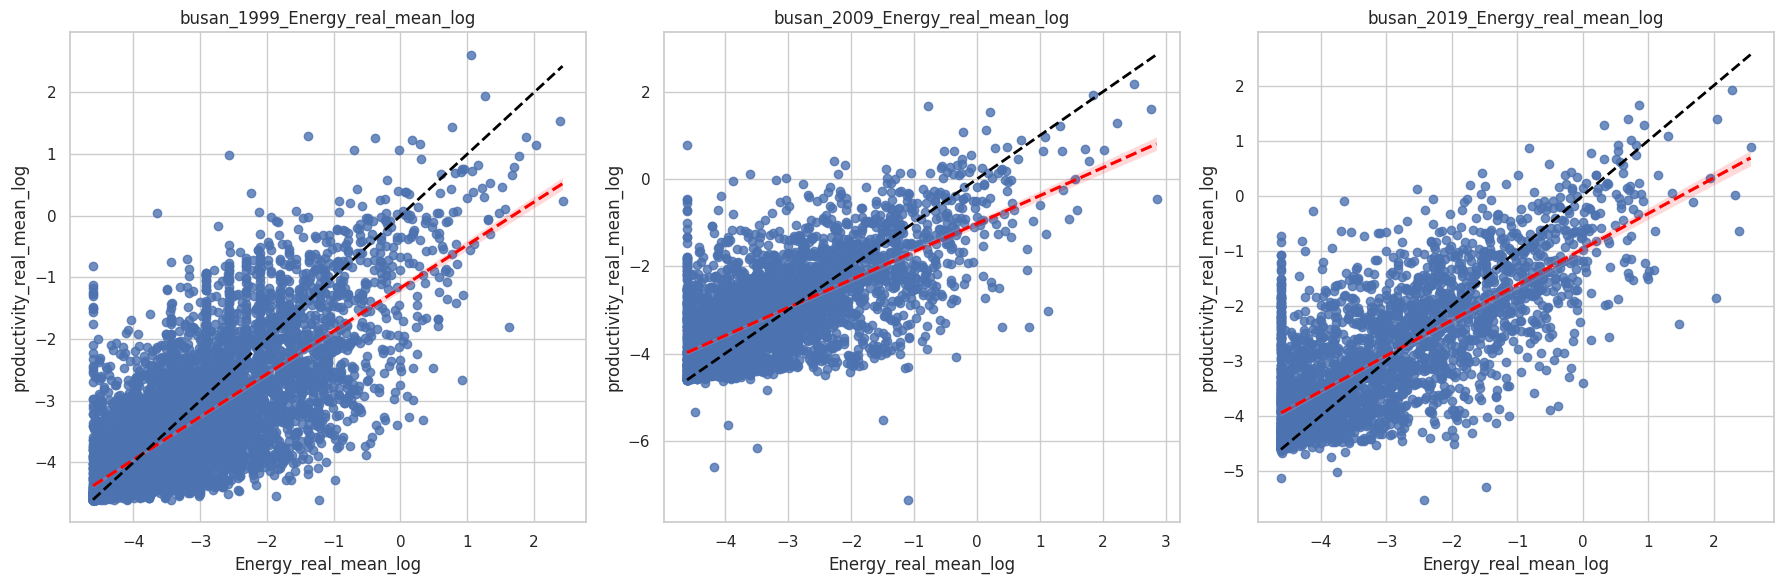

In [51]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_busan[city_data_busan['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 광주

In [52]:
# 행정지역 필터링
city = '광주'
city_name = 'gwangju'
city_data_gwangju = city_data[city_data['c_city'] == city]

In [53]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_gwangju[city_data_gwangju['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.906
Model:                                    OLS   Adj. R-squared:                  0.906
Method:                         Least Squares   F-statistic:                     4031.
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:15   Log-Likelihood:                -320.48
No. Observations:                        1259   AIC:                             649.0
Df Residuals:                            1255   BIC:                             669.5
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

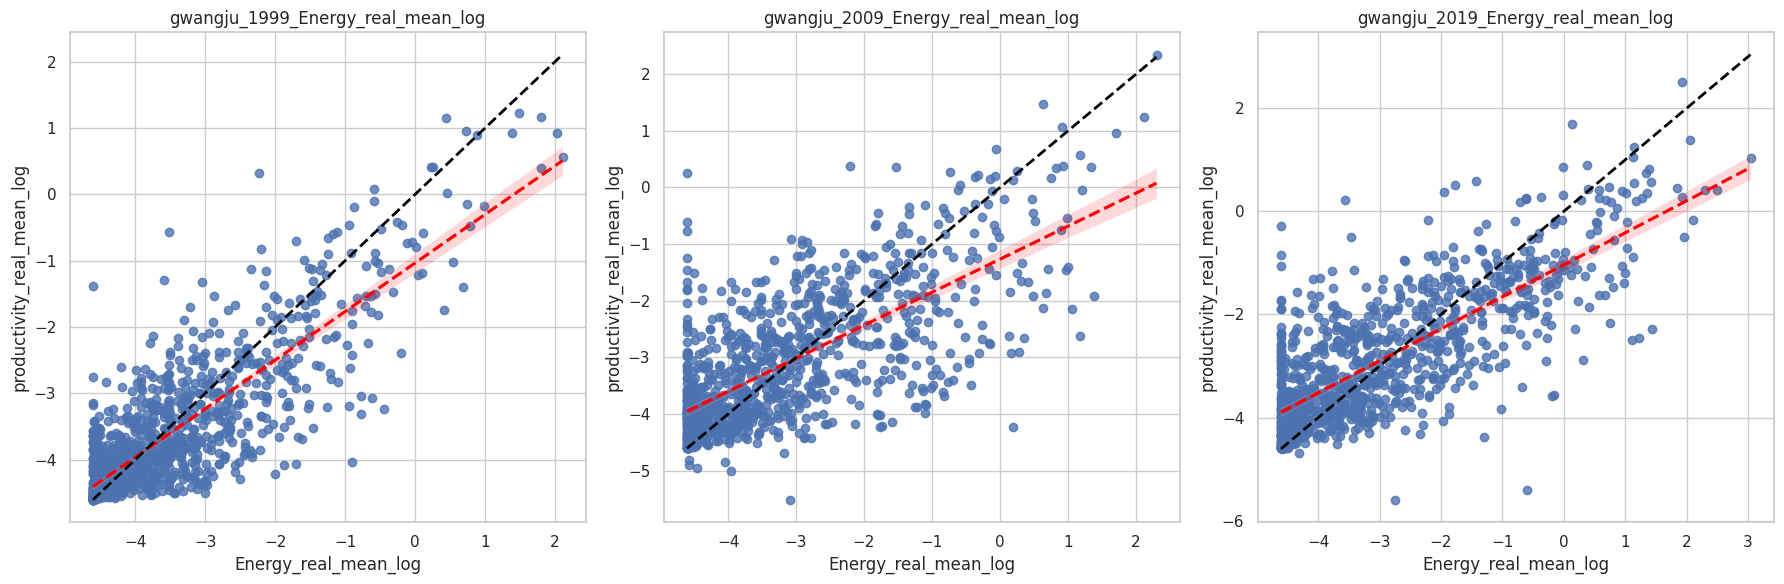

In [54]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_gwangju[city_data_gwangju['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 대전

In [55]:
# 행정지역 필터링
city = '대전'
city_name = 'daejeon'
city_data_daejeon = city_data[city_data['c_city'] == city]

In [56]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_daejeon[city_data_daejeon['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.896
Model:                                    OLS   Adj. R-squared:                  0.896
Method:                         Least Squares   F-statistic:                     3404.
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:16   Log-Likelihood:                -438.66
No. Observations:                        1189   AIC:                             885.3
Df Residuals:                            1185   BIC:                             905.6
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

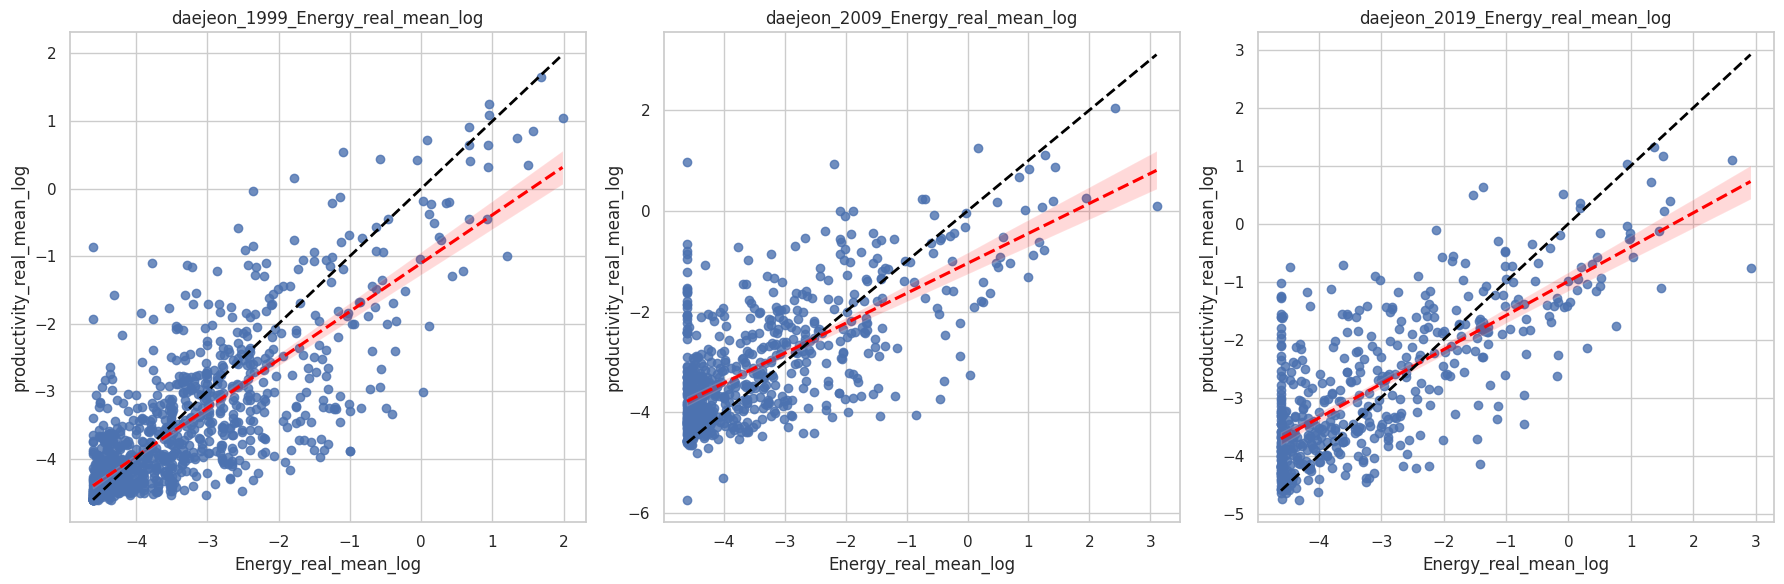

In [57]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_daejeon[city_data_daejeon['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 대구

In [58]:
# 행정지역 필터링
city = '대구'
city_name = 'daegu'
city_data_daegu = city_data[city_data['c_city'] == city]

In [59]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_daegu[city_data_daegu['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.883
Model:                                    OLS   Adj. R-squared:                  0.883
Method:                         Least Squares   F-statistic:                 1.496e+04
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:17   Log-Likelihood:                -1754.4
No. Observations:                        5923   AIC:                             3517.
Df Residuals:                            5919   BIC:                             3544.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

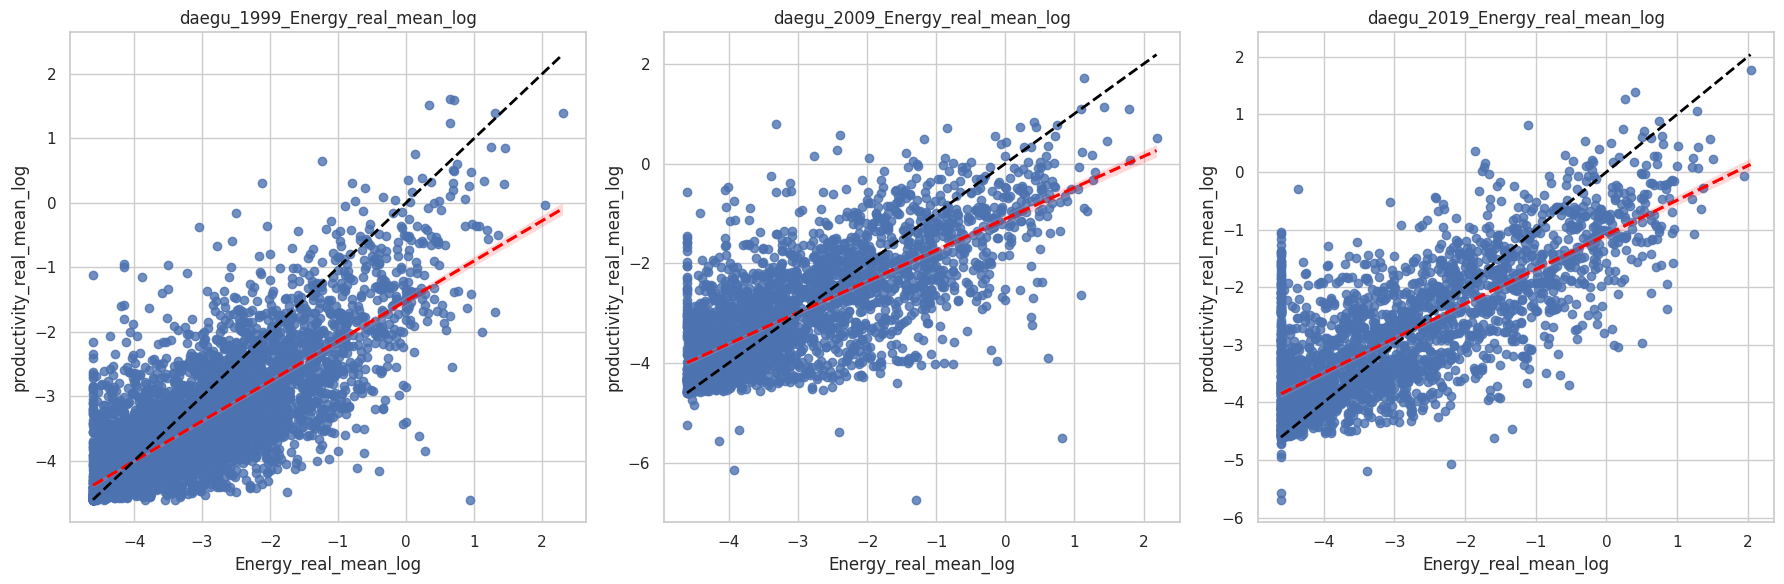

In [60]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_daegu[city_data_daegu['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 인천

In [61]:
# 행정지역 필터링
city = '인천'
city_name = 'incheon'
city_data_incheon= city_data[city_data['c_city'] == city]

In [62]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_incheon[city_data_incheon['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.894
Model:                                    OLS   Adj. R-squared:                  0.894
Method:                         Least Squares   F-statistic:                 2.051e+04
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:19   Log-Likelihood:                -2493.9
No. Observations:                        7330   AIC:                             4996.
Df Residuals:                            7326   BIC:                             5023.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

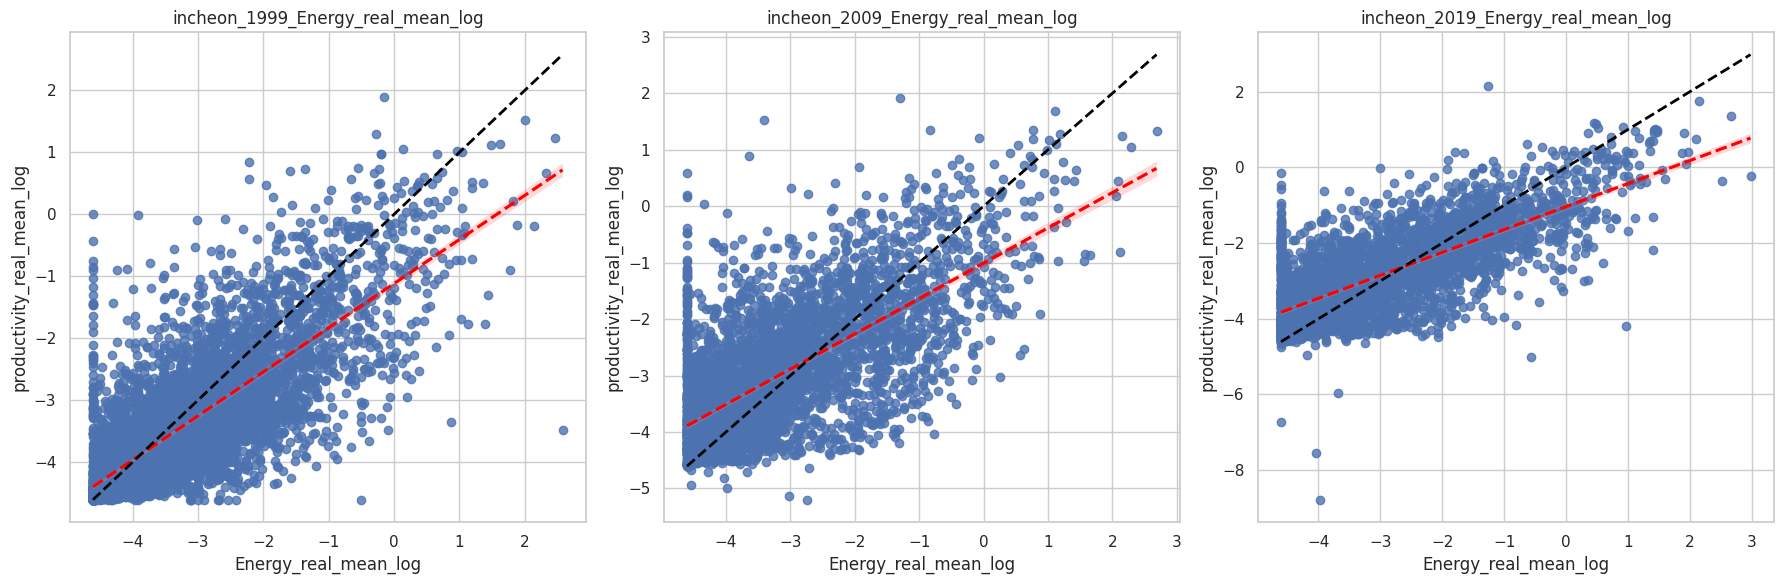

In [63]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_incheon[city_data_incheon['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

- 행정구역 : 울산

In [64]:
# 행정지역 필터링
city = '울산'
city_name = 'ulsan'
city_data_ulsan= city_data[city_data['c_city'] == city]

In [65]:
# 연도별로 회귀분석 실행
for year in years:
    city_data_year = city_data_ulsan[city_data_ulsan['year'] == year]
    perform_regression(year, city_data_year)

Regression Results for 1999:
                                OLS Regression Results                                
Dep. Variable:     productivity_real_mean_log   R-squared:                       0.901
Model:                                    OLS   Adj. R-squared:                  0.901
Method:                         Least Squares   F-statistic:                     3495.
Date:                        Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                                14:10:21   Log-Likelihood:                -615.00
No. Observations:                        1150   AIC:                             1238.
Df Residuals:                            1146   BIC:                             1258.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------

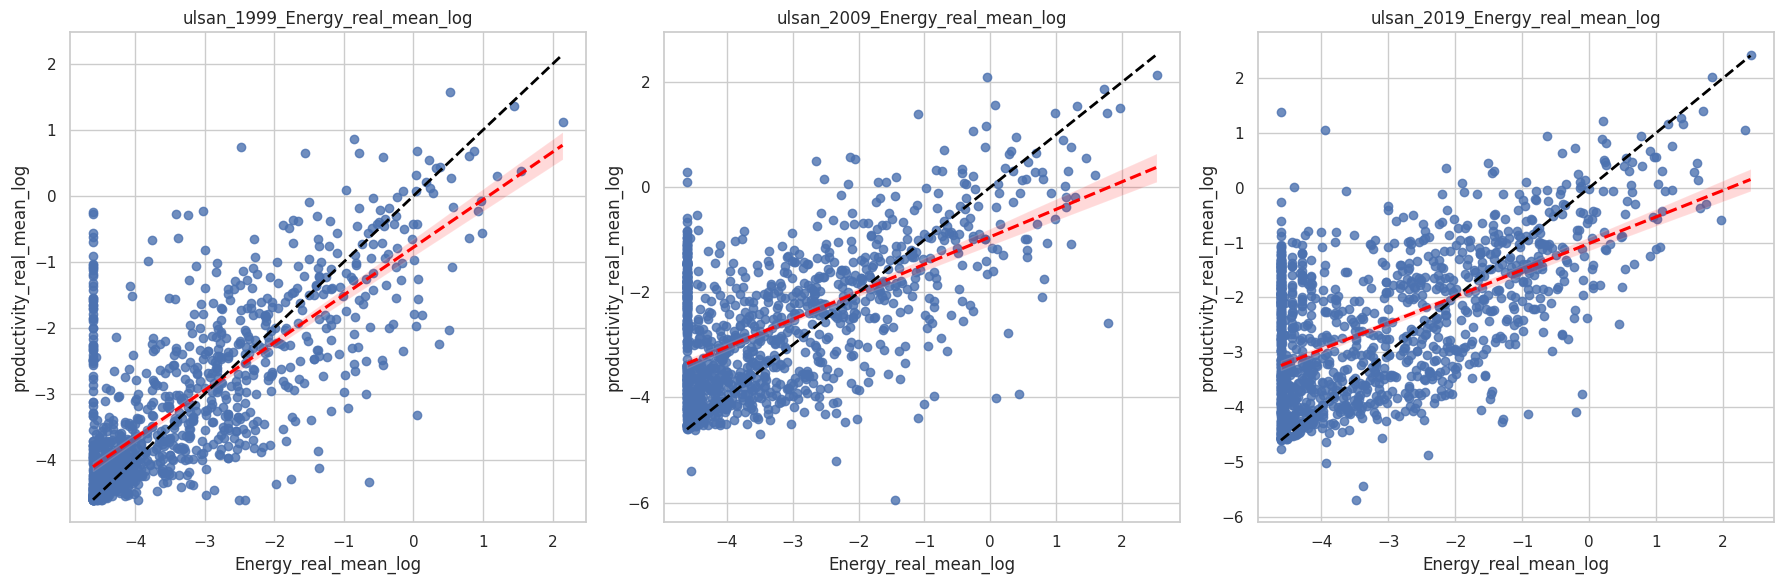

In [66]:
# 1행 3열의 서브플롯을 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, year in enumerate(years):
    city_data_year = city_data_ulsan[city_data_ulsan['year'] == year]
    plot_scatter_and_regression(year, city_data_year, var, ax=axes[i])

plt.tight_layout()
plt.show()

## 4-1.실질부가가치 성장률과 온실가스 배출량 성장률


실질 부가가치 성장률 도출 방법

* 기업의 실질부가가치 = 기업의 부가가치 / 제조업 대표 물가지수(119.84)
* 기업의 실질부가가치 변화율
* 연도별 기업의 실질 부가가치 변화율의 중앙값
* 지역 순서 : 서울,부산,광주,대전,대구,인천,울산

In [170]:
def made_real_vadd_growth(df):
    manu_price_index = 119.84
    df['real_vadd_growh'] = df['vadd'] / manu_price_index
    df['real_vadd_growh'] = df['real_vadd_growh'].pct_change() * 100
    real_price_growth = pd.DataFrame(df.groupby('year')['real_vadd_growh'].median())
    return real_price_growth

def real_vadd_growth_gas_graph(city_df,gas_df):
    vadd_df = made_real_vadd_growth(city_df).reset_index().rename(columns = {'year':'YEAR'})
    tmp = gas_df[9:][['YEAR','MADE']].reset_index(drop=True)
    merge_df = pd.merge(tmp,vadd_df, on='YEAR')

    # graph size
    plt.figure(figsize=(10, 5))
    # first y-axis(manufacture gas emission)
    plt.plot(df['YEAR'], df['MADE'], label='Gas_Emission', color='blue')
    plt.ylabel('MADE', color='blue')
    plt.tick_params(axis='y', labelcolor='blue')

    # second y-axis(real_add_growth)
    plt.twinx()
    plt.plot(df['YEAR'], df['real_vadd_growh'], label='Real_Vadd_Growh', color='green')
    plt.ylabel('real_add_growth', color='green')
    plt.tick_params(axis='y', labelcolor='green')

    # x-axis (year)
    plt.xlabel('YEAR')
    plt.title('Gas Emission & Real Vadd Growh by year')
    plt.legend(loc='upper left')
    plt.ylim(-5,5)
    plt.show()

In [ ]:
# 서울
real_vadd_growth_gas_graph(city_data_seoul,seoul_gas)

In [ ]:
# 부산
real_vadd_growth_gas_graph(city_data_busan,busan_gas)

In [ ]:
# 광주
real_vadd_growth_gas_graph(city_data_gwangju,gwangju_gas)

<ipython-input-170-c06e33540985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['vadd'] / manu_price_index
<ipython-input-170-c06e33540985>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['real_vadd_growh'].pct_change() * 100


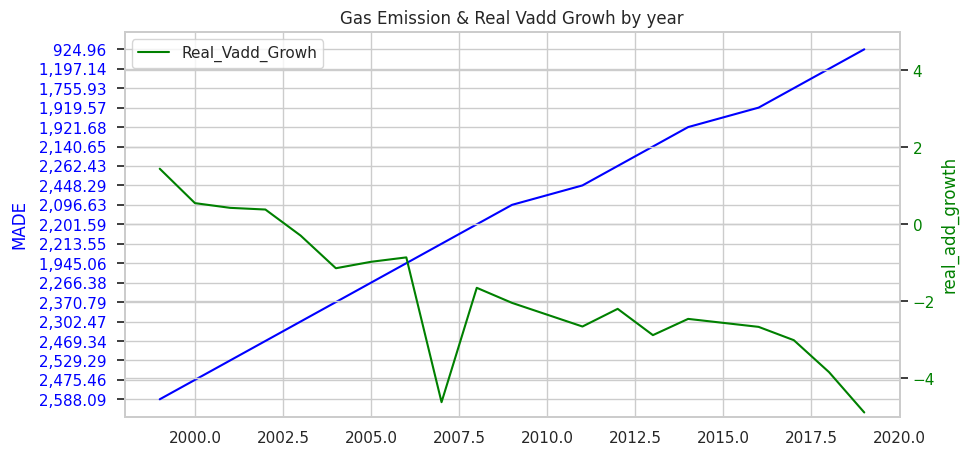

In [172]:
# 대전
real_vadd_growth_gas_graph(city_data_daejeon,daejeon_gas)

<ipython-input-170-c06e33540985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['vadd'] / manu_price_index
<ipython-input-170-c06e33540985>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['real_vadd_growh'].pct_change() * 100


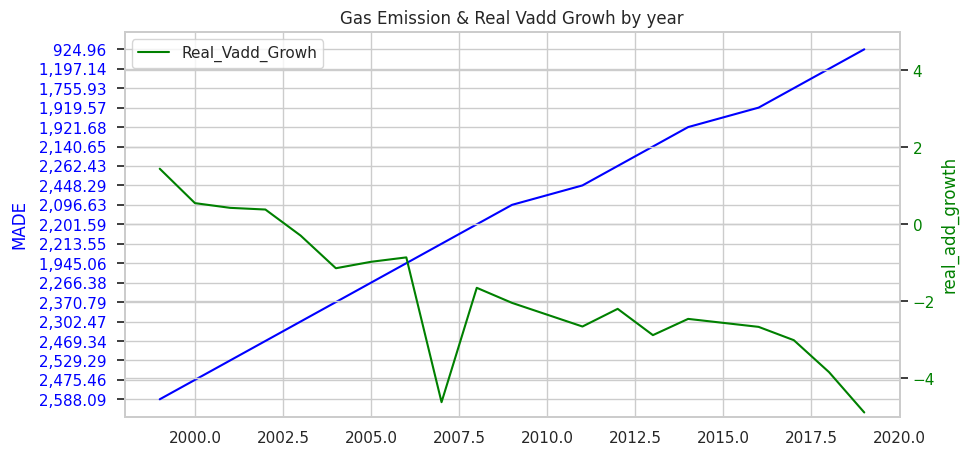

In [173]:
# 대구
real_vadd_growth_gas_graph(city_data_daegu,daegu_gas)

<ipython-input-170-c06e33540985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['vadd'] / manu_price_index
<ipython-input-170-c06e33540985>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['real_vadd_growh'].pct_change() * 100


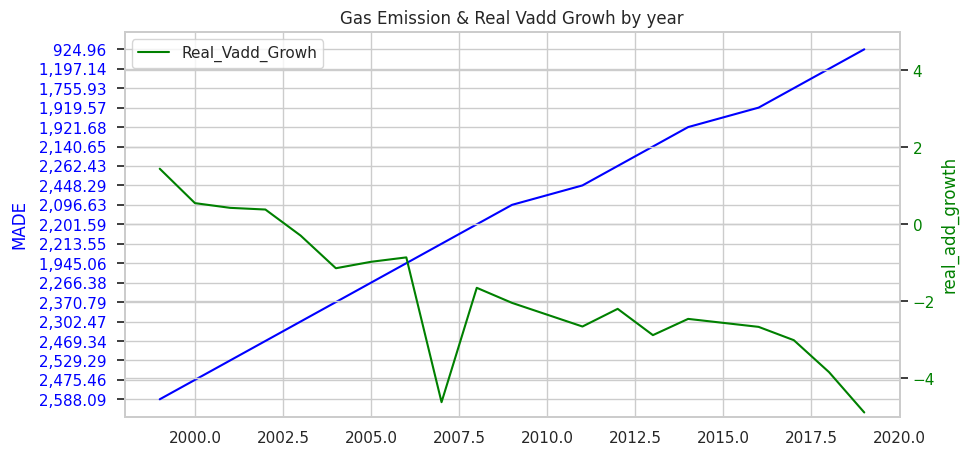

In [174]:
# 인천
real_vadd_growth_gas_graph(city_data_incheon,incheon_gas)

<ipython-input-170-c06e33540985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['vadd'] / manu_price_index
<ipython-input-170-c06e33540985>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['real_vadd_growh'] = df['real_vadd_growh'].pct_change() * 100


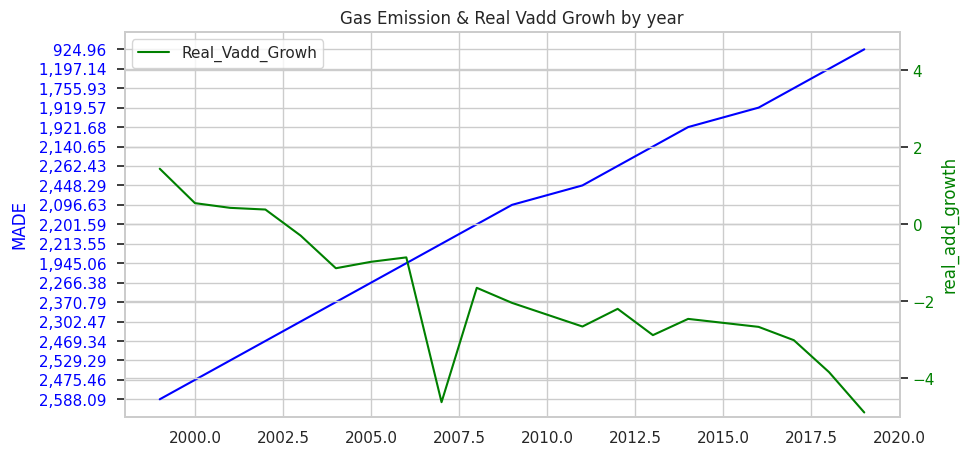

In [175]:
# 울산
real_vadd_growth_gas_graph(city_data_ulsan,ulsan_gas)